# Glacier Analysis Notebook 

Featuring all of the steps of our project

Chloe Bruce and Megan Byers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import csv
import statsmodels.api as sm 
from scipy import stats

# 1.1 Converting GLIMS .dbf files to .csv

Below is the Python script used to translate the .dbf files from the GLIMS database into .csv

~~~~
import csv
from dbfpy import dbf
import os
import sys

filename = sys.argv[1]
if filename.endswith('.dbf'):
    print "Converting %s to csv" % filename
    csv_fn = filename[:-4]+ ".csv"
    with open(csv_fn,'wb') as csvfile:
        in_db = dbf.Dbf(filename)
        out_csv = csv.writer(csvfile)
        names = []
        for field in in_db.header.fields:
            names.append(field.name)
        out_csv.writerow(names)
        for rec in in_db:
            out_csv.writerow(rec.fieldData)
        in_db.close()
        print "Done..."
else:
  print "Filename does not end with .dbf"

~~~~

# 2.1 First preview into the GLIMS & WGI Datasets

As you can see, the WGI dataset included a lot of information we didn't need, such as contient, free positon 
and local glacier codes. We did the same dropping of irrelevant columns on the GLIMS set. 

In [2]:
#Opening the original WGI file 
pd.set_option('display.max_columns', 50)
wgi_original = 'wgi_original.csv'
wgi = pd.read_csv(wgi_original)
wgi = wgi.drop(columns = ['political_unit', 'glacier_name', 'easting', 'northing','longi_profile','mean_length', 'source_nourish','continent_code', 'drainage_code', 'free_position_code', 'local_glacier_code', 'coordinate_description', 'num_basins',  'max_elev', 'mean_elev', 'min_elev', 'min_elev_exp', 'mean_elev_acc', 'mean_elev_abl', 'primary_class', 'form', 'frontal_char','moraines1', 'moraines2','period_activity_start', 'period_activity_end', 'snow_line_elev', 'snow_line_acy', 'snow_line_date', 'mean_depth', 'depth_acy','area_in_state', 'area_exp', 'mean_width','max_length', 'max_length_exp', 'max_length_abl', 'orientation_acc', 'orientation_abl', 'data_contributor', 'remarks']) 
print("The original WGI file has",len(wgi), "entries")
wgi.rename(columns={'wgi_glacier_id':'GLAC_ID','total_area':"DB_AREA"}, inplace=True)
#print(list(wgi))
wgi.head(5)

The original WGI file has 132890 entries


,GLAC_ID,lat,lon,topo_year,topo_scale,photo_year,tongue_activity,DB_AREA,area_acy
0,AF5Q112B0009,34.807,68.891,1959.0,100000.0,NaN,0.0,0.53,3.0
1,AF5Q112C0025,35.438,69.552,1959.0,100000.0,NaN,0.0,0.34,3.0
2,AF5Q112C0085,35.869,70.224,1959.0,100000.0,NaN,0.0,0.59,3.0
3,AF5Q112C0146,35.458,70.023,1959.0,100000.0,NaN,0.0,0.20,3.0
4,AF5Q112C0151,35.409,69.959,1959.0,100000.0,NaN,0.0,0.28,3.0


In [3]:
file = 'glims_original.csv'
glims = pd.read_csv(file)
glims = glims.drop(columns = ['LINE_TYPE','PRIMECLASS', 'ANLYS_TIME', 'MIN_ELEV', 'MEAN_ELEV','LOCAL_ID','RELEASE_DT', 'RC_ID', 'MAX_ELEV','PARENT_ID','REC_STATUS', 'GLAC_NAME','PROC_DESC', 'SUBMITTERS', 'ANALYSTS', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30','CHIEF_AFFL']) 
print("The original GLIMS file has",len(glims),"entries")
glims.head(5)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (22,26,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The original GLIMS file has 691372 entries


,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA
0,101215,G286929E46788S,12.4259,12.4292,0.0,4786.66,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula
1,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula
2,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula
3,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula
4,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula


# 2.2 Formating date 

For the sake of readability. 


In [4]:
glims['DATE'] = pd.to_datetime(glims['SRC_DATE'])
glims['YEAR'] = glims['DATE'].dt.year
glims['MONTH'] = glims['DATE'].dt.month
#glims.head()

# 2.3 Merging GLIMS and WGI 


As you can see above, the WGI dataset uses ids starting with A, and the GLIMS dataset uses IDs start with G. We 
created a quick filter to see if the WGI had any pairable ids. 

The GLIMS dataset has a category called "WGMS_ID", we wanted to see if we could pair this way. 

In [5]:
#create a list of ids that are matching each other 
glims_ids = list(set(glims["WGMS_ID"]))
wgi_ids = list(set(wgi["GLAC_ID"]))
matchlist =(set(glims_ids) & set(wgi_ids))


print("Number of matching IDs between WGI & GLIMS:",len(matchlist)) 

Number of matching IDs between WGI & GLIMS: 4860


Success! We could now merge the values together. 

In [6]:
#glims_v2 = glims.merge(wgi, how='left', left_on='WGMS_ID', right_on='GLAC_ID')

#glims_v2.rename(columns={' total_area':'DB_AREA'}, inplace=True)
#print("The length after adding WGI to GLIMS original 691,372 entries is",len(glims_v2))

#glims_v2.head()

Now, we needed to give both data sets the same column names, in order to merge them.. 

# 2.4 Merging latitude-longitude into GLIMS 

Now, we wanted to make sure our GLIMS file had latitude and longitude points, so we could see what we were working with. 

First, we translated the "points.dbf" file into a csv.

In [7]:
coordinates = pd.read_csv('LatLong_GLIMS.csv')
print("The number of unique glaciers in GLIMS is",len(glims.GLAC_ID.unique()),"which is equivalent to the number of coordinate values,",len(coordinates))
coordinates.drop(coordinates.columns[3], axis=1,inplace=True) #dropping extra column
coordinates.head()

The number of unique glaciers in GLIMS is 253867 which is equivalent to the number of coordinate values, 253867


,X,Y,glacier_id
0,1.187,-70.166,G001187E70166S
1,2.050,-70.629,G002050E70629S
2,2.939,-70.509,G002939E70509S
3,3.296,-54.422,G003296E54422S
4,3.299,-54.407,G003299E54407S


In [8]:
glims_v1 = glims.merge(coordinates, how='left', left_on='GLAC_ID', right_on='glacier_id')
glims_v1.drop(glims_v1.columns[16], axis=1,inplace=True) #dropping extra glacier_id column
glims_v1.rename(columns={'X':'long', 'Y':'lat'}, inplace=True)
glims_v1.head()

,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
0,101215,G286929E46788S,12.4259,12.4292,0.0,4786.66,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.071,-46.788
1,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
2,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
3,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
4,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755


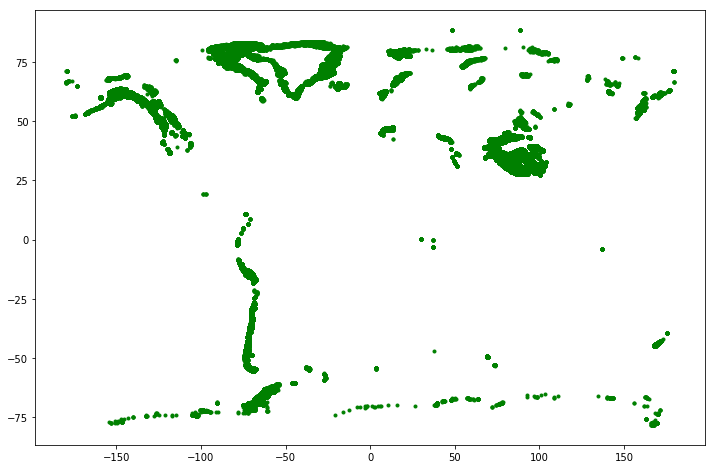

In [9]:
# want to see if the points look accurate
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(glims_v1['long'], glims_v1['lat'], color='green', marker='.')

Hey! That looks like our planet! 

# 3.1 Checking out our data & removing duplicate entries (round one)

After looking individually at some of the glacier ids, we realized that there were many duplicates, all under the same analysis id. So, we eliminated duplicate analysis ids. This shrank our number of viable entries drastically. 

In [10]:
glims_v1.loc[glims["GLAC_ID"]=="G286719E46755S"]
#you can see many entries with the analysis id, the same area, and the same src_date 

,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
1,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
2,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
3,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
4,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
5,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
6,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
7,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
23,102307,G286719E46755S,82.3281,82.3572,0.0,10536.7,1974-06-30T00:00:00,None,exists,561,Antarctic Peninsula,1974-06-30,1974,6,-73.281,-46.755
97,102307,G286719E46755S,82.3281,82.3572,0.0,10536.7,1974-06-30T00:00:00,None,exists,561,Antarctic Peninsula,1974-06-30,1974,6,-73.281,-46.755
326,101763,G286719E46755S,80.2842,80.3127,0.0,10225.6,2001-08-04T00:00:00,None,exists,560,Antarctic Peninsula,2001-08-04,2001,8,-73.281,-46.755


In [11]:
glims_v2 = glims_v1.drop_duplicates(subset=['ANLYS_ID'])
print("After deleting duplicates, the length of the glims file is",len(glims_v2),"compared to the original, which had",len(glims_v1))

#verifying this correctly dropped the values
glims_v2.loc[glims_v1["GLAC_ID"]=="G286719E46755S"]


After deleting duplicates, the length of the glims file is 371045 compared to the original, which had 691372


,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
1,101146,G286719E46755S,80.2842,80.3127,0.0,10225.6,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755
23,102307,G286719E46755S,82.3281,82.3572,0.0,10536.7,1974-06-30T00:00:00,None,exists,561,Antarctic Peninsula,1974-06-30,1974,6,-73.281,-46.755
326,101763,G286719E46755S,80.2842,80.3127,0.0,10225.6,2001-08-04T00:00:00,None,exists,560,Antarctic Peninsula,2001-08-04,2001,8,-73.281,-46.755
151370,107826,G286719E46755S,80.0724,80.1009,0.0,10009.3,1986-01-14T00:00:00,None,exists,565,Antarctic Peninsula,1986-01-14,1986,1,-73.281,-46.755
152517,102437,G286719E46755S,108.6900,108.7280,0.0,13793.1,1870-01-01T00:00:00,None,exists,562,Antarctic Peninsula,1870-01-01,1870,1,-73.281,-46.755
427001,313243,G286719E46755S,7.6830,65.9919,0.0,0.0,2000-06-15T00:00:00,None,exists,592,761,2000-06-15,2000,6,-73.281,-46.755
673214,2113,G286719E46755S,66.3400,66.3749,0.0,0.0,2001-03-11T00:00:00,None,exists,98,20,2001-03-11,2001,3,-73.281,-46.755


# 3.2 Looking at numbers of entries per glacier 

We needed multiple data entries to ensure we could actually see a gradual change over time. So, we looked at what we were working with: 

In [12]:
numGlacierObs = glims_v2['GLAC_ID'].value_counts()

to_drop = ['Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS']
glims_v2[~glims_v2['GEOG_AREA'].isin(to_drop)]

numGlacierObs

G069498E49566S    15
G068865E49596S    11
G295607E81938N     8
G295826E81956N     8
G011078E47093N     7
G011065E47076N     7
G011118E46985N     7
G011127E47028N     7
G286330E47046S     7
G011065E47126N     7
G286936E52937S     7
G286698E52880S     7
G011115E47043N     7
G286627E47050S     7
G286763E52863S     7
G286988E52950S     7
G286886E52763S     7
G286959E52797S     7
G011028E47111N     7
G286992E52939S     7
G286498E47448S     7
G287045E52664S     7
G011145E47051N     7
G286916E53002S     7
G011075E47118N     7
G011095E47076N     7
G286951E52763S     7
G286668E46885S     7
G011120E47095N     7
G286858E52858S     7
                  ..
G278164E73479N     1
G283896E81304N     1
G239412E54116N     1
G289956E32973S     1
G291366E55189S     1
G231603E53231N     1
G294735E66443N     1
G079623E30919N     1
G275370E81191N     1
G327754E67999N     1
G242118E52295N     1
G077702E68826S     1
G318170E63425N     1
G170888E43331S     1
G074334E40697N     1
G246618E48557N     1
G076587E40771

Text(0,0.5,'Number of Glaciers')

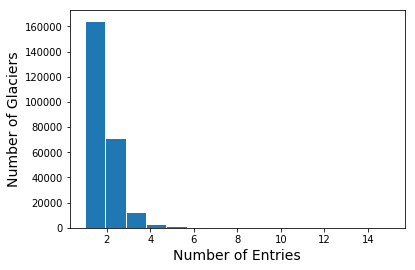

In [13]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(numGlacierObs, bins = 15, edgecolor='white')
ax.set_xlabel("Number of Entries",fontsize=14)
ax.set_ylabel("Number of Glaciers",fontsize=14)

Well... that's a bummer. A significantly small number of our glaciers have over 4 entries.

# 3.3 Removing glaciers with less than 4 entries


In [14]:
#Let's try to get the "good IDs"

#To start, these are the glaciers with more than 3 observations
allIDs = glims_v2.GLAC_ID.unique()
goodIDs = []
for i in allIDs:
    if numGlacierObs[i] > 3:
        goodIDs.append(i)
    
print("Original number of entries:",len(glims_v2))
print("Number of glaciers with over 3 entries:",len(goodIDs))

Original number of entries: 371045
Number of glaciers with over 3 entries: 5565


# 3.4 Looking for more errors in our data 

After removing duplicates with analysis ids, we looked again to see what we were working with. The same glacier we looked at above still had duplicates - 13/15 of them were on the same day, March 2001 - and with different areas, nonetheless. 

In [15]:
glims_v2.loc[glims_v2['GLAC_ID'] == 'G069498E49566S']

,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
360485,288270,G069498E49566S,26.214,26.214400,0.0,0.0,1964-04-01T00:00:00,None,exists,585,761,1964-04-01,1964,4,69.498,-49.566
666994,64478,G069498E49566S,0.000,60.060700,-999.0,-999.0,1963-06-01T00:00:00,None,exists,525,Kerguelen Island,1963-06-01,1963,6,69.498,-49.566
667213,64652,G069498E49566S,0.000,0.033506,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667367,64629,G069498E49566S,0.000,29.538400,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667560,64632,G069498E49566S,0.000,0.629075,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667600,64653,G069498E49566S,0.000,0.056251,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667606,64677,G069498E49566S,0.000,0.011381,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667609,64660,G069498E49566S,0.000,0.078090,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667627,64697,G069498E49566S,0.000,0.098463,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566
667640,64661,G069498E49566S,0.000,0.076467,0.0,0.0,2001-03-09T00:00:00,None,exists,527,Kerguelen Island,2001-03-09,2001,3,69.498,-49.566


Text(0.5,1,'Glacier ID: G069498E49566S')

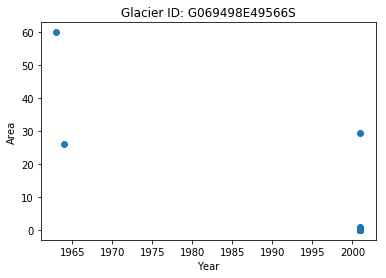

In [16]:
x =glims_v2[glims_v2['GLAC_ID']== 'G069498E49566S']['DB_AREA']
y =glims_v2[glims_v2['GLAC_ID']== 'G069498E49566S']['YEAR']

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(y,x)
ax.set_xlabel("Year")
ax.set_ylabel("Area")
ax.set_title("Glacier ID: G069498E49566S")

# 3.5 Removing (more) duplicate dates 

In [17]:
greatIDs = []

#Now find glaciers with 4 or more obs on unique dates
for i in goodIDs:
    glc = glims_v2.loc[glims_v2['GLAC_ID'] == i]
    if (len(glc.DATE.unique()) >= 4):
        greatIDs.append(i)
    
    #this appends to greatIDs glaciers with 4 or more dates

In [18]:
print("After filtering duplicate dates, there are",len(greatIDs),"glaciers")

After filtering duplicate dates, there are 4390 glaciers


Now, we can look at some other glaciers in the dataset and make sure their data is correct. 

Text(0.5,1,'Glacier ID: G069498E49566S')

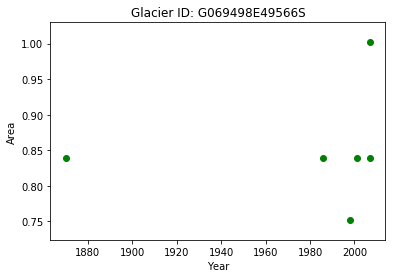

In [19]:
#making a subplot to test for errors in data duplication 
glims_v3 = glims_v2.loc[glims_v2['GLAC_ID']==greatIDs[50]]
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.scatter(glims_v3['YEAR'], glims_v3['DB_AREA'], color='green', marker='o')
ax.set_xlabel("Year")
ax.set_ylabel("Area")
ax.set_title("Glacier ID: G069498E49566S")

#need to check 5 & 50 especially 

In [20]:
#new data frame with all the good glaciers 

glims_v4 = glims_v2.loc[glims_v2['GLAC_ID']==greatIDs[0]]
glims_v4.head(100)
#finally, the data had no repeating dates or entries. 

,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
0,101215,G286929E46788S,12.4259,12.4292,0.0,4786.66,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.071,-46.788
150165,101886,G286929E46788S,13.1393,13.1428,0.0,4786.66,2001-08-04T00:00:00,None,exists,560,Antarctic Peninsula,2001-08-04,2001,8,-73.071,-46.788
152783,102506,G286929E46788S,15.3202,15.3244,0.0,5285.27,1870-01-01T00:00:00,None,exists,562,Antarctic Peninsula,1870-01-01,1870,1,-73.071,-46.788
162454,107884,G286929E46788S,13.6053,13.6089,0.0,5270.57,1986-01-14T00:00:00,None,exists,565,Antarctic Peninsula,1986-01-14,1986,1,-73.071,-46.788


In [21]:
for i in np.arange(1,len(greatIDs)):
    glacier_list = glims_v2.loc[glims_v2['GLAC_ID']==greatIDs[i]]
    glims_v4 = glims_v4.append(glacier_list)

#glims_v4.head(1000)

The cleaned dataset has 21442 data points


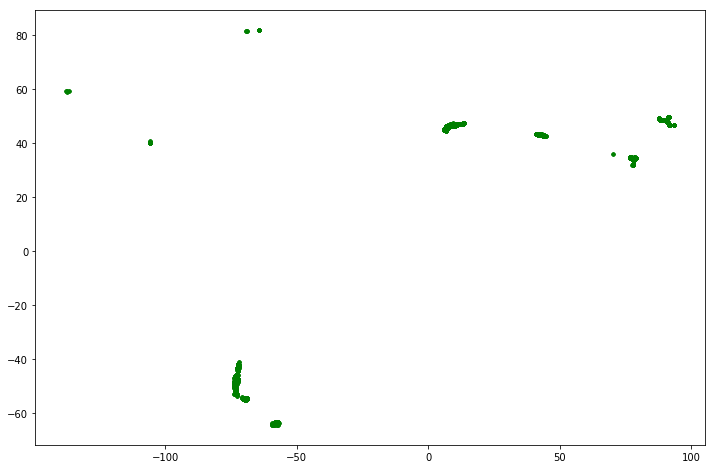

In [22]:
print("The cleaned dataset has",len(glims_v4),"data points")
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.scatter(glims_v4['long'], glims_v4['lat'], color='green', marker='.')

Our dataset has changed quite a bit since we started cleaning. 

# 4.1 Analyzing the data - Multiple Linear Regression 

We wanted to see in latitudinal position affect decline of glaciers. 

In [23]:
ids = glims_v4.GLAC_ID.unique()

#SLR or MLR?
#MLR with year and absolute value of latitude as predictors of area
glims_v5 = glims_v4.loc[glims_v4['GLAC_ID']==ids[0]]
glims_v5 = glims_v5[['DB_AREA','YEAR','lat']] #only select 3 columns
glims_v5 = glims_v5.abs() #absolute value

X = glims_v5[['YEAR','lat']]
# Add a constant to the array for the intecept 
X = sm.add_constant(X) 
y = glims_v5['DB_AREA']
model = sm.OLS(y, X).fit()

In [24]:
model.summary()
#Strong collinearity, not well suited for MLR

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                DB_AREA   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     24.06
Date:                Mon, 06 May 2019   Prob (F-statistic):             0.0391
Time:                        01:23:14   Log-Likelihood:               -0.79919
No. Observations:                   4   AIC:                             5.598
Df Residuals:                       2   BIC:                             4.371
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
YEAR          -0.0183      0.004     -4.905      0.039      -0.034      -0.002
lat            1.0609      0.157      6.758      0.021       0.385       1.736
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.659
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.351
Skew:                          -0.413   Prob(JB):                        0.839
Kurtosis:                       1.806   Cond. No.                     1.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 4.2 Simple Linear Regression 

MLR did not like the constant nature of latitude. So, testing for area over time. 

In [25]:
len(ids)
glims_v4.head()

,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
0,101215,G286929E46788S,12.4259,12.4292,0.0,4786.66,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.071,-46.788
150165,101886,G286929E46788S,13.1393,13.1428,0.0,4786.66,2001-08-04T00:00:00,None,exists,560,Antarctic Peninsula,2001-08-04,2001,8,-73.071,-46.788
152783,102506,G286929E46788S,15.3202,15.3244,0.0,5285.27,1870-01-01T00:00:00,None,exists,562,Antarctic Peninsula,1870-01-01,1870,1,-73.071,-46.788
162454,107884,G286929E46788S,13.6053,13.6089,0.0,5270.57,1986-01-14T00:00:00,None,exists,565,Antarctic Peninsula,1986-01-14,1986,1,-73.071,-46.788
1,101146,G286719E46755S,80.2842,80.3127,0.0,10225.60,2007-09-06T00:00:00,None,exists,559,Antarctic Peninsula,2007-09-06,2007,9,-73.281,-46.755


In [26]:
#SLR
#data frame to store results
results = pd.DataFrame(columns=['id', 'geog_area', 'slope','intercept','stderror','pval'])
#from scipy import stats
for i in ids:
    glims_v5 = glims_v4.loc[glims_v4['GLAC_ID']==i]
    glacId = glims_v5.iloc[0,1]
    area = glims_v5.iloc[0,10]
    bhat, ahat, rval, p, stderr = stats.linregress(glims_v5["YEAR"], glims_v5["DB_AREA"])
    data = pd.DataFrame([{'id': glacId, 'geog_area': area, 'slope': bhat, 'intercept': ahat, 'stderror': stderr, 'pval': p}])
    results = results.append(data)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [27]:
glims_v5

,ANLYS_ID,GLAC_ID,AREA,DB_AREA,WIDTH,LENGTH,SRC_DATE,WGMS_ID,GLAC_STAT,SUBM_ID,GEOG_AREA,DATE,YEAR,MONTH,long,lat
682922,2090,G302183E64143S,80.4700,80.5418,1.1,17.8,2001-01-08T13:14:49,None,exists,96,Glacier area determined by thresholding ASTER...,2001-01-08 13:14:49,2001,1,-57.817,-64.143
690495,100526,G302183E64143S,75.6828,75.7406,0.0,16591.6,2009-03-03T00:00:00,None,exists,554,565,2009-03-03 00:00:00,2009,3,-57.817,-64.143
690884,100699,G302183E64143S,76.7875,76.8463,0.0,17563.1,1988-02-29T00:00:00,None,exists,555,565,1988-02-29 00:00:00,1988,2,-57.817,-64.143
691258,100900,G302183E64143S,76.0939,76.1521,0.0,17034.1,2001-01-08T00:00:00,None,exists,556,565,2001-01-08 00:00:00,2001,1,-57.817,-64.143


In [28]:
glims_v5.head()
l = np.array(range(len(results)))
results.set_index(l, inplace=True)
results

,geog_area,id,intercept,pval,slope,stderror
0,Antarctic Peninsula,G286929E46788S,49.638132,0.039139,-0.018317,0.003734
1,Antarctic Peninsula,G286719E46755S,600.380219,0.006041,-0.262915,0.057620
2,Antarctic Peninsula,G286570E46600S,395.926050,0.032993,-0.135465,0.046384
3,Antarctic Peninsula,G286829E48560S,132.114842,0.131107,-0.045552,0.022079
4,Antarctic Peninsula,G287590E47667S,54.611658,0.015945,-0.024578,0.004979
5,Antarctic Peninsula,G290552E54592S,-4.760517,0.821891,0.015551,0.063341
6,Antarctic Peninsula,G286431E47184S,671.791243,0.002315,-0.200528,0.029068
7,Antarctic Peninsula,G290587E54704S,172.205667,0.002078,-0.082368,0.008170
8,Antarctic Peninsula,G286716E46597S,287.830274,0.101906,-0.101061,0.050524
9,Antarctic Peninsula,G286599E47361S,409.107784,0.002465,-0.166188,0.029561


# 4.3 Looking at individual areas 

In [29]:
#what are the geographic areas of the results?
results.geog_area.unique()

array(['Antarctic Peninsula', '536', 761, 602, '561', '33', 'French Alps',
       'Himalaya (India, Nepal, Bhutan)', '5', 'Swiss Alps', '761',
       'Austrian Alps', '34', '12', 'Caucausus Region',
       ' Glacier area determined by thresholding ASTER 3/4 ratio image using the catchment polygo'],
      dtype=object)

In [30]:
#how many pvals are < 0.1?
#2518/4390
sigresults = results.loc[results['pval'] <= 0.1]
sigresults.geog_area.unique()

array(['Antarctic Peninsula', 761, 602, '561', '33', 'French Alps', '5',
       'Himalaya (India, Nepal, Bhutan)', 'Swiss Alps', '34',
       'Austrian Alps', '12', 'Caucausus Region'], dtype=object)

In [31]:
#geographic areas
antarctic = sigresults.loc[sigresults['geog_area'] == 'Antarctic Peninsula']
alps = sigresults.loc[(sigresults['geog_area'] == 'French Alps') | (sigresults['geog_area'] == 'Swiss Alps') | (sigresults['geog_area'] == 'Austrian Alps')]
usa = sigresults.loc[sigresults['geog_area'] == 'Conterminous USA']
himalaya = sigresults.loc[sigresults['geog_area'] == 'Himalaya (India, Nepal, Bhutan)']
caucasus = sigresults.loc[sigresults['geog_area'] == 'Caucausus Region']

Antarctic: 261

Alps: 1775

USA: 4

Himalaya: 78

Caucasus: 316

Text(0,0.5,'Count')

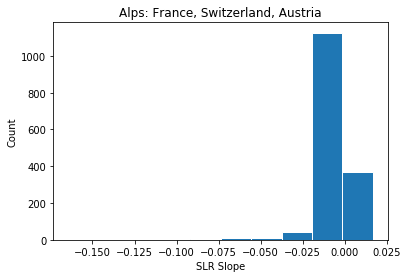

In [32]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(alps['slope'], bins = 10, edgecolor='white')
plt.title('Alps: France, Switzerland, Austria')
plt.xlabel('SLR Slope')
plt.ylabel('Count')

Text(0,0.5,'Count')

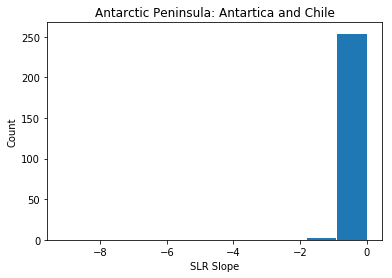

In [33]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(antarctic['slope'], bins = 10, edgecolor='white')
plt.title('Antarctic Peninsula: Antartica and Chile')
plt.xlabel('SLR Slope')
plt.ylabel('Count')

Text(0,0.5,'Count')

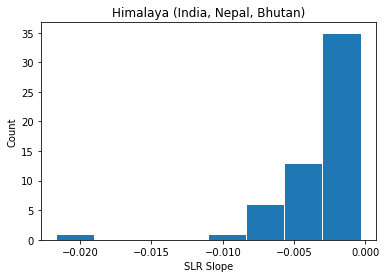

In [34]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(himalaya['slope'], bins = 8, edgecolor='white')
plt.title('Himalaya (India, Nepal, Bhutan)')
plt.xlabel('SLR Slope')
plt.ylabel('Count')

Text(0,0.5,'Count')

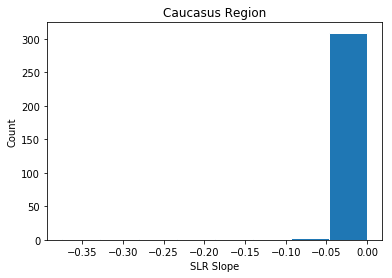

In [35]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.hist(caucasus['slope'], bins = 8, edgecolor='white')
plt.title('Caucasus Region')
plt.xlabel('SLR Slope')
plt.ylabel('Count')

## Median slopes by region:

antarctic = -0.029

alps = -0.003

himalaya = -0.002

caucasus = -0.006


## Mean slopes by region

antarctic = -0.129

alps = -0.0055

himalaya = -0.0028

caucasus = -0.012
















